<a href="https://colab.research.google.com/github/prachishete/DeepLearning/blob/main/CNN/SignLanguageMNIST/02_Sign_Language_CNN_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

#### In this series of experiments, we will train a CNN network on a dataset for Sign Language for Alphabets and will try to improve the accuracy with different techniques
#### In this 2nd experiment we will add [batch normalization](https://arxiv.org/abs/1502.03167) and we will note the accuracy of the updated network.

# [Batch Normalization](https://arxiv.org/abs/1502.03167)
#### In Deep neural network, as weights and biases are getting updated after each epoch, the inputs to the neurons changes. This change in the distribution of inputs is known as internal covariate shift. Batch Normalization not only takes care of internal covariate shift but also Vanishing and exploding gradients in case of saturated activation functions. 

# **Download Dataset**

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download datamunge/sign-language-mnist
! mkdir Sign_Language_MNIST
! unzip sign-language-mnist.zip -d Sign_Language_MNIST

 91% 57.0M/62.6M [00:00<00:00, 71.8MB/s]
100% 62.6M/62.6M [00:00<00:00, 72.8MB/s]
Archive:  sign-language-mnist.zip
  inflating: Sign_Language_MNIST/amer_sign2.png  
  inflating: Sign_Language_MNIST/amer_sign3.png  
  inflating: Sign_Language_MNIST/american_sign_language.PNG  
  inflating: Sign_Language_MNIST/sign_mnist_test.csv  
  inflating: Sign_Language_MNIST/sign_mnist_test/sign_mnist_test.csv  
  inflating: Sign_Language_MNIST/sign_mnist_train.csv  
  inflating: Sign_Language_MNIST/sign_mnist_train/sign_mnist_train.csv  


# **Import the libraries**
#### We will set the seed so that the initial random values set in the experiment will be same throughout the series. This will help in comparing the accuracies as we change the hyperparameters of the network

In [4]:
import random
import numpy as np
import tensorflow as tf

seed=7
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# **Read and Pre-process the dataset into Train, Validate and Test dataset**

In [6]:
#Read Dataset files 
train = pd.read_csv('Sign_Language_MNIST/sign_mnist_train.csv')
test = pd.read_csv('Sign_Language_MNIST/sign_mnist_test.csv')

#Covert to numpy array
train_set = np.array(train, dtype = 'float32')
test_set = np.array(test, dtype='float32')

#Specify class lables
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]

#Preprocess the dataset
X_train = train_set[:, 1:] / 255
y_train = train_set[:, 0]

X_test = test_set[:, 1:] / 255
y_test = test_set[:,0]

#Split training dataset into train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 12345)

#Reshape datasets
X_train = X_train.reshape(X_train.shape[0], *(28, 28, 1))
X_test = X_test.reshape(X_test.shape[0], *(28, 28, 1))
X_validate = X_validate.reshape(X_validate.shape[0], *(28, 28, 1))

# **Import Libraries for CNN**

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau

# **Defining the Convolutional Neural Network**

In [8]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        input_shape=(28, 28, 1), 
                        padding="same"
                        ))
cnn_model.add(Activation('relu'))

cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     padding="same"
                     ))
cnn_model.add(Activation('relu'))

cnn_model.add(BatchNormalization())

cnn_model.add(MaxPooling2D(pool_size=(2,2),
                           strides=(2,2)))

cnn_model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     padding="same"
                     ))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     padding="same"
                     ))
cnn_model.add(Activation('relu'))

cnn_model.add(BatchNormalization())

cnn_model.add(MaxPooling2D(pool_size=(2,2),
                           strides=(2,2)))

cnn_model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3), 
                     padding="same"
                     ))
cnn_model.add(Activation('relu'))

cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(filters=128, 
                     kernel_size=(3, 3), 
                     padding="same"
                     ))
cnn_model.add(Activation('relu'))

cnn_model.add(BatchNormalization())

cnn_model.add(MaxPooling2D(pool_size=(2,2),
                           strides=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 25, 
                    activation = 'softmax'
                    ))

#CNN Model Summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

# **Training the Model**

In [9]:
#Compiling
optimizer = Adam(learning_rate=0.003)
cnn_model.compile(loss ='sparse_categorical_crossentropy', 
                  optimizer=optimizer ,
                  metrics =['accuracy'])

#Training the CNN model
history = cnn_model.fit(X_train, y_train, batch_size = 512, epochs = 100, verbose = 1, validation_data = (X_validate, y_validate))


Epoch 1/100
43/43 [==============================] - 19s 92ms/step - loss: 0.9730 - accuracy: 0.7845 - val_loss: 3.9298 - val_accuracy: 0.0426
Epoch 2/100
43/43 [==============================] - 3s 59ms/step - loss: 0.0095 - accuracy: 0.9999 - val_loss: 5.5727 - val_accuracy: 0.0379
Epoch 3/100
43/43 [==============================] - 3s 59ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.0727 - val_accuracy: 0.0392
Epoch 4/100
43/43 [==============================] - 3s 59ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.2849 - val_accuracy: 0.0455
Epoch 5/100
43/43 [==============================] - 3s 59ms/step - loss: 9.6177e-04 - accuracy: 1.0000 - val_loss: 9.2772 - val_accuracy: 0.0539
Epoch 6/100
43/43 [==============================] - 3s 59ms/step - loss: 7.0797e-04 - accuracy: 1.0000 - val_loss: 9.5994 - val_accuracy: 0.0652
Epoch 7/100
43/43 [==============================] - 3s 59ms/step - loss: 5.4896e-04 - accuracy: 1.0000 - val_loss: 8.9167 - val_accuracy: 

# **Analysing the Performance**

Text(0.5, 1.0, 'Accuracy evolution')

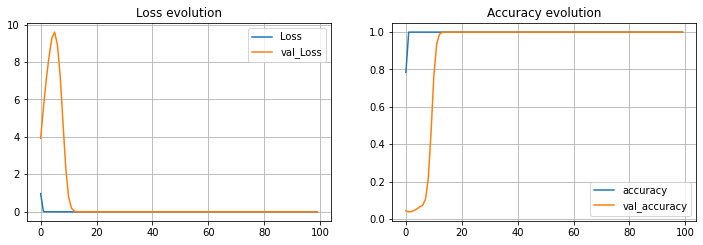

In [10]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# **Analysing the Predictions**

In [11]:
#Predictions for the test data
predicted_classes=np.argmax(cnn_model.predict(X_test) ,axis=1)


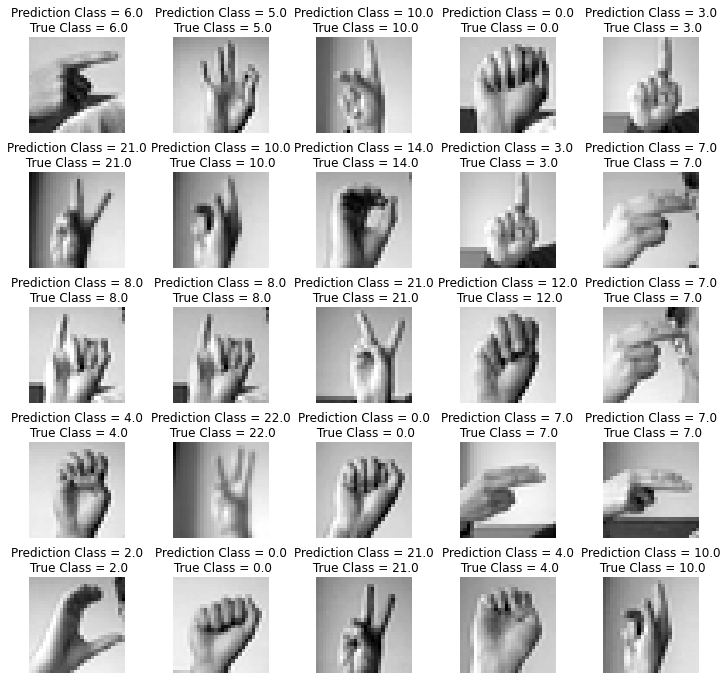

In [12]:
#Visualize predictions
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28), cmap='gray')
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# **[Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)**
#### [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is used to define / visualize / summarise performance of a machine learning classification algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.

 |          | Predicted Positive | Predicted Negative | 
 | :-: | :-: |:-: |
 |Actual  Positive |    TP    |    FN    |
 | Actual Negative |    FP    |    TN    |


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predicted_classes)

In [14]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

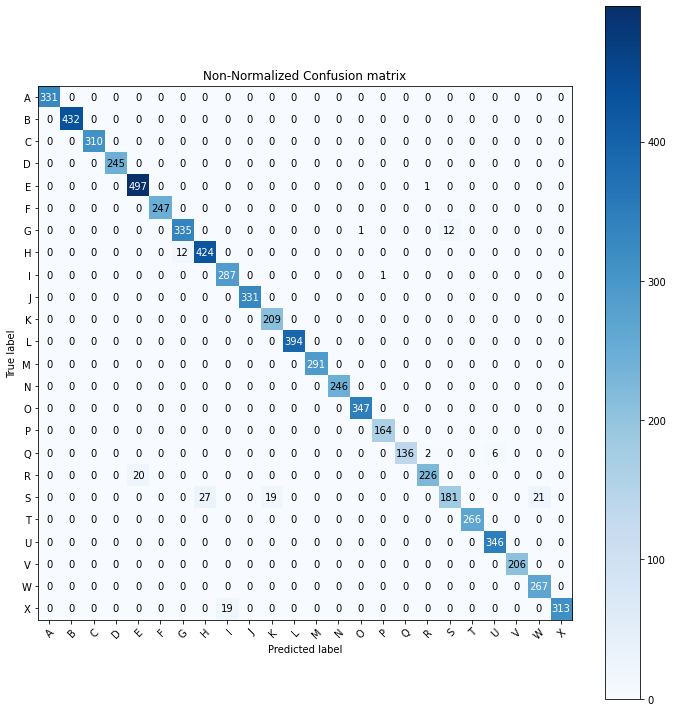

In [15]:
#Specifying class labels
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.show()

Normalized confusion matrix


<Figure size 2520x2520 with 0 Axes>

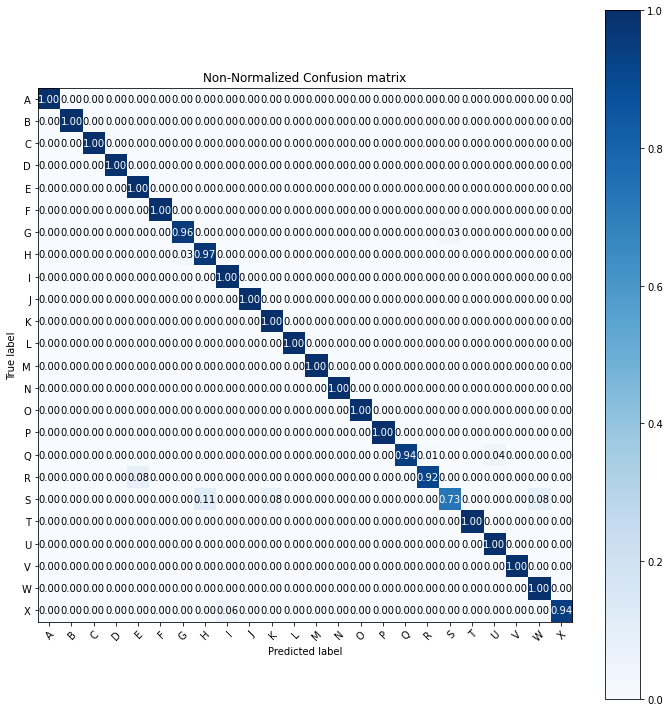

In [16]:
#Normalized Confusion Matrix
plt.figure(figsize=(35,35))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, normalize=True, title='Non-Normalized Confusion matrix')
plt.show()

# **Accuracy Calculation**

In [17]:
#Classification accuracy
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, predicted_classes)
print('Accuracy Score = ',acc_score)

Accuracy Score =  0.980340211935304


# **Conclusion**
#### [Batch Normalization](https://arxiv.org/abs/1502.03167) has improved the accuracy from 92.93% to 98.03%
#### In [the next experiment](./03_Sign_Language_CNN_RG.ipynb) we will try using regularization to generalise the model predictions.